In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
datapath = '/Users/carmennab/Dropbox/met_office/data/'
foam = np.array(Dataset(datapath+'experiments/EASE_grid/rosie_UCL_CTL_NOSIT_ASSIM_r243541_dcarneir.nc')['snvolu'])
smlg = np.array(Dataset(datapath+'snow_depths/SMLG/EASE_snowdepth20161001-20170430.nc')['Snow Depth'])
awi = np.array(Dataset(datapath+'snow_depths/AWI/EASE_snowdepth20161001-20170430.nc')['Snow Depth'])

sits = [foam,smlg,awi]
names = ['FOAM','SM-LG','AWI']

### plot timeseries

In [3]:
days = np.arange(0,212)
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','East Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

old_lon = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lon_25km.npy')
old_lat = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lat_25km.npy')
new_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/EASE/lat_25km_cent.npy')
new_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/EASE/lon_25km_cent.npy')

mask = regrid(mask_values,old_lon,old_lat,new_lons,new_lats)

means = {}

for name,sit in zip(names,sits):
    means[name] = np.array([np.nanmean(sit[day]) for day in days])

means['SM-LG'][np.isnan(means['FOAM'])] = np.nan
means['AWI'][np.isnan(means['FOAM'])] = np.nan
    
for region, reg in zip(regions, regs):
    data = {}
    for name,sit in zip(names,sits):
        sit_c = sit.copy()
        for day in days:
            sit_c[day][~np.isin(mask,reg)] = np.nan
        data[name] = np.array([np.nanmean(sit_c[day]) for day in days])
        
    data['SM-LG'][np.isnan(data['FOAM'])] = np.nan
    data['AWI'][np.isnan(data['FOAM'])] = np.nan
        
    means[region] = data

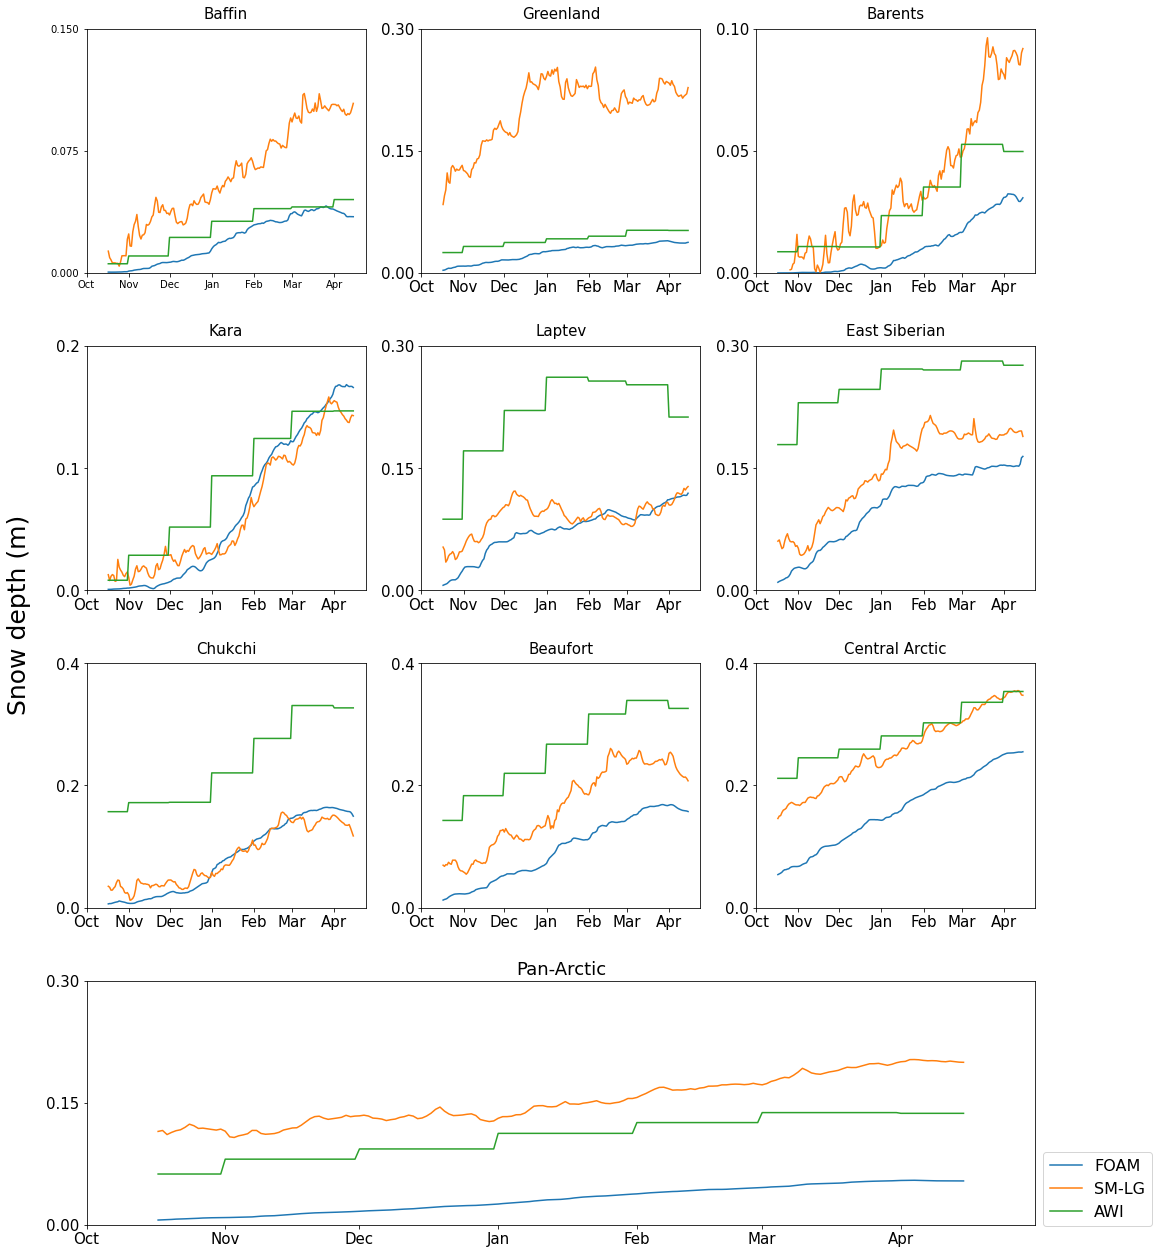

In [4]:
fig = plt.figure(figsize=(17,22))
spec = gridspec.GridSpec(ncols=3, nrows=4, wspace=0.2,hspace=0.3)
ylims = [0.15,0.3,0.1,0.2,0.3,0.3,0.4,0.4,0.4]

for count,region in enumerate(regions):
    data = means[region]
    ax = fig.add_subplot(spec[count])
    ax.set_title(region,pad=10,fontsize=15)
    for name in names:
        ax.plot(days,data[name],label=name)
    ax.set_xticks([0,31,61,92,123,151,182])
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr'])
    ax.set_ylim([0,ylims[count]])
    plt.rc('font', size=15)
    ax.set_yticks([0,ylims[count]/2,ylims[count]])
    
ax = fig.add_subplot(spec[9:12])
for name in names:
    ax.plot(days,means[name],label=name)
ax.set_ylim(0,0.3)
ax.set_xlim(0,212)
ax.set_title('Pan-Arctic')
ax.set_xticks([0,31,61,92,123,151,182])
ax.set_yticks([0,0.15,0.3])
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr'])  
ax.legend(bbox_to_anchor = (1, 0.33),fontsize=16)

fig.text(0.07, 0.45, 'Snow depth (m)', ha='center',fontsize=25,rotation='vertical')
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/supp_figs/snow_regional_timeseries.png',
            dpi=400, bbox_inches="tight")